In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from itertools import combinations

In [2]:
def nDimGrid(*Xs):
    
    '''
    Create N-dimension grid, as list of Nxn points from N 1D array of n values.
    It returns a 2D array of a shape (Nxn, N), each line being a point 
    in the n-dim space.
   
    For example, to create a 3D grid in a [0, 1] x [0, 1] x [0, 1] cube
      - 10 values along the x-axis
      - 15 values along the y-axis
      - 20 values along the z-axis
    
    One would do the following
    
    >>> Xs = np.linspace(0, 1, 10)
    >>> Ys = np.linspace(0, 1, 15)
    >>> Zs = np.linspace(0, 1, 20)
    >>> grid = nDimGrid(Xs, Ys, Zs)
    >>> print(grid.shape) 
    >>>
    >>> (3000, 3)
    '''
    
    return np.array(np.meshgrid(*Xs)).T.reshape(-1, len(Xs))

In [3]:
def plotPdf2D(Xs, Ys, PDF2d, kwargs_scatter={}, kwargs_coutour={}):
    
    '''
    Xs, Ys: 1D-array
    PDF: callable f(points) where points is a 2D array of 
         a shape (n, 2) returning 1d array of n values.
    '''
    
    # Creates all (x, y) points from Xs and Ys
    points = nDimGrid(Xs, Ys)

    # Compute the proba for all these pairs
    proba = PDF2d(points)
    
    # Plot it using a scatter
    x, y = points[:, 0], points[:, 1]
    plt.scatter(x, y, c=proba, **kwargs_scatter);

    # Produce a contour plot, coming back to meshgrid
    XX, YY = np.meshgrid(Xs, Ys)
    PP = proba.reshape(len(Xs), len(Ys)).T
    plt.contour(XX, YY, PP, **kwargs_coutour);

In [4]:
def plotDataProj2D(data, kwargs_scatter={}):
    '''
    Plot projection over all variables pairs (Xi, Xj) of a
    dataset with N points of n-dimension.
    
    data: array with a shape (N, n)
    '''

    # Create all variable pairs (with indices)
    pairIdx = list(combinations(range(data.shape[1]), 2))

    # Plot scatter matrix
    N = len(pairIdx)/2
    plt.figure(figsize=(5*N, 5*N))

    # Plot projection for each pair of variables
    for i, j in pairIdx:
        iPlot = i*N + j
        plt.subplot(N, N, iPlot)
        plt.scatter(data[:, j], data[:, i], **kwargs_scatter)
        plt.xlabel('var{}'.format(j))
        plt.ylabel('var{}'.format(i))

        
def plotPdfProj2D(points, PDF, kwargs_scatter={}):
    
    '''
    Plot projection over all variables pairs (Xi, Xj) of a dimension n
    probability density function evaluated overs N points {(x1, ..., xNdim)}_N:
     --> probability = PDF(X1, ..., XNdim)
    
    points: array with a shape (N, n)
    PDF: callable f(points) where points is a 2D array of 
         a shape (N, n) returning 1d array of N values.
    '''

    # Compute the probabilities
    proba = PDF(points)
    
    # Sort points into increasing proba - for cosmetic purpose
    sIdx = np.argsort(proba)
    probaS = proba[sIdx]
    pointS = points[sIdx]

    kwargs_scatter['c'] = probaS
    plotDataProj2D(pointS, kwargs_scatter)

In [5]:
class multivariate_skew_normal():
    
    
    def __init__(self, mean, sigma, cov, skew):
        
        '''
        For a skew gaussian of N dimension:
          mean  = 1d array of shape N
          sigma = 1d array of shape N
          cov   = 2d array of shape NxN
          skew  = 1d array of shape N
          
        mv_skew_normal = Normal(X.T * cov * X) x NormalCumulative(skew.T * X)
        '''
        
        # conversion in numpy array
        mean  = np.array(mean)
        sigma = np.array(sigma)
        cov   = np.array(cov)
        skew  = np.array(skew)
        
        # Handle 1D case
        if mean.ndim == 0:
            mean = mean[np.newaxis]
            sigma = sigma[np.newaxis]
            cov   = cov[np.newaxis, np.newaxis]
            skew  = skew[np.newaxis]
        
        # Assign attributes
        self.loc   = mean
        self.skew  = skew
        self.scale = np.diag(sigma)
        self.cov   = self.scale @ cov @ self.scale
        self.dim   = mean.shape[0]

        
    def pdf(self, x):
        
        '''
        Compute the PDF value in a point in the N-dimension space.
        Two shapes are accepted for x:
          - 1 point : 1D array of shape N and pdf(x) returns a number
          - n points: 2D array of shape nxN and pdf(x) returns an array of shape n.
        '''
        
        # Format input properly
        x = np.array(x)
        if x.ndim == 0:
            x = x[np.newaxis]
        else:
            x = x.reshape(-1, self.dim)
        
        # Compute the gaussian part
        multinorm = stats.multivariate_normal.pdf(x-self.loc, cov=self.cov)        
        
        # Compute the skewed part
        alpha = np.matmul(self.skew, np.linalg.inv(self.scale))[np.newaxis, :]   
        xNorm = (x-self.loc)[..., np.newaxis]
        beta  = np.squeeze(np.matmul(alpha, xNorm))
        cdf   = stats.norm.cdf(beta)
        
        # Return the result
        return 2 * multinorm * cdf

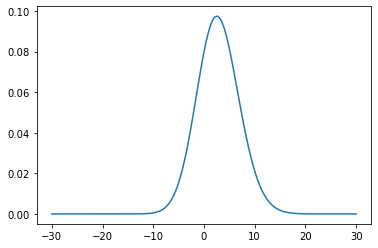

In [6]:
# 1D example
sn1D = multivariate_skew_normal(0, 5, 1, 1)

# Plot 
xs = np.linspace(-30, 30, 1000)
pr = sn1D.pdf(xs)
plt.plot(xs, pr);

In [7]:
# 2D example
mean  = [7, 10]
sigma = [14, 12]
skew  = [-2, 10]
cov   = np.array([[1, 0.9], [0.9, 1]])
sn2D  = multivariate_skew_normal(mean, sigma, cov, skew)

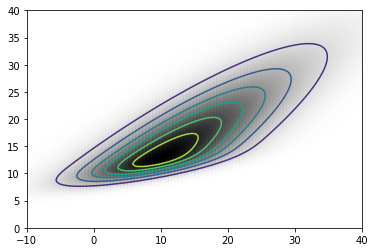

In [8]:
# Create a list of Xs and Ys
xs = np.linspace(-10, 40, 100)
ys = np.linspace(  0, 40, 100)
plotPdf2D(xs, ys, sn2D.pdf, kwargs_scatter={'cmap': 'gray_r'});

In [9]:
# 4D example
mean  = [15]*4
sigma = [2]*4
cov   = np.array([
        [1,     0,   0, 0.7],
        [  0,   1, 0.3,   0],
        [  0, 0.3,   1,   0],
        [0.7,   0,   0,   1],
    ])
skew = [-7, 0, 0, 15]

sn4D = multivariate_skew_normal(mean, sigma, cov, skew)

In [10]:
sn4D.pdf([15, 11, 13, 18])

6.34560829143672e-05

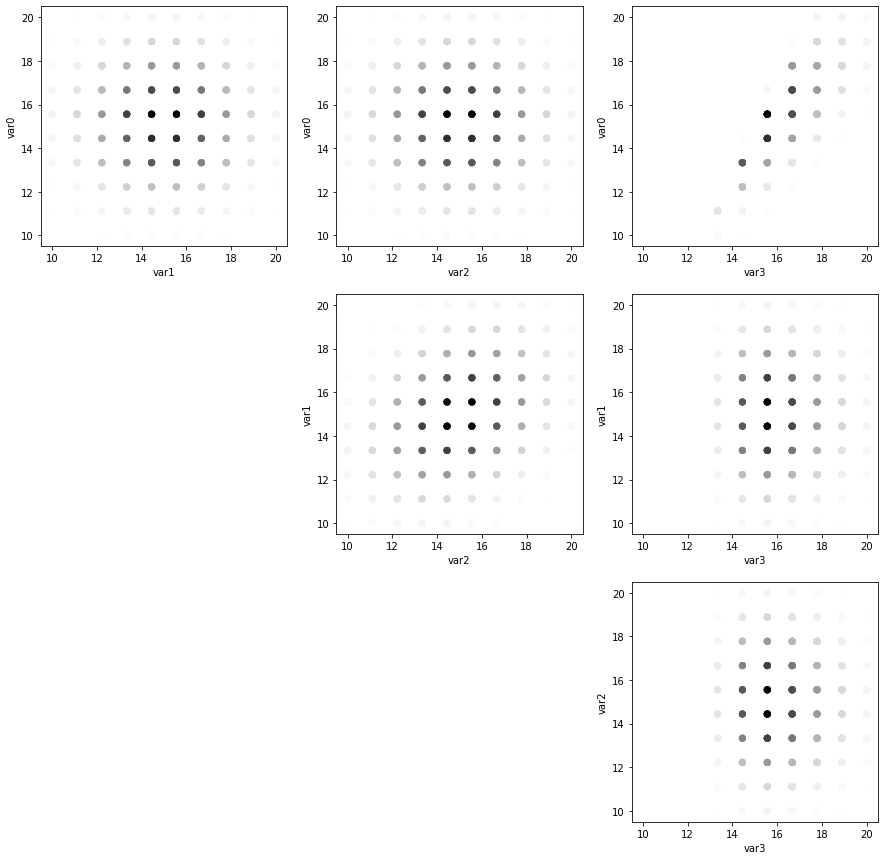

In [11]:
# Make a 4D grid using meshgrid.
X = np.linspace(10, 20, 10)
data = nDimGrid(X, X, X, X)
plotPdfProj2D(data, sn4D.pdf, kwargs_scatter={'cmap': 'gray_r'})

In [12]:
def generateToys(pdf, n, xLim):
    
    '''
    Return a dataset distributed according the given pdf. This is an array of
    shape (Naccepted, Ndim) where Naccepted is a priori unknown.
    
    pdf : callable pdf(x) where x can be a 2D array of shape (Npoints, Ndim)
    n   : number of generated toys
    xLim: 2D array of shape (Ndim, 2) containing limits which defined variable space scan.
    '''
    
    # Limits and dimension of initial space
    xLim = np.array(xLim)
    nDim = xLim.shape[0]
    
    # Border values for PDF
    Xs = np.array([np.random.rand(n)*(xLim[i][1]-xLim[i][0]) + xLim[i][0] for i in range(nDim)]).T
    Ys = np.random.rand(n) * np.max(pdf(Xs))
    
    # Return x values of kept points
    return Xs[pdf(Xs)>=Ys]

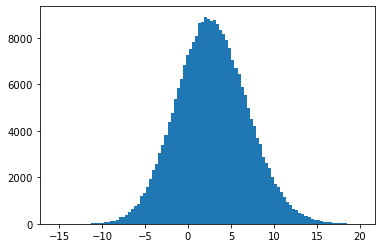

In [13]:
# 1D example
sn1D = multivariate_skew_normal([0], [5], [[1]], [1])
data = generateToys(sn1D.pdf, 1000000, xLim=[[-20, 20]])
plt.hist(data, bins=100);

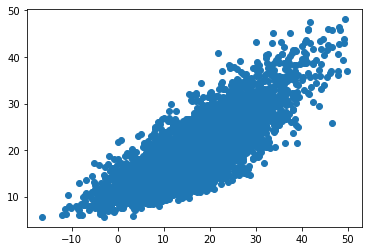

In [14]:
# 2D example
mean  = [7, 10]
sigma = [14, 12]
skew  = [-2, 10]
cov   = np.array([[1, 0.9], [0.9, 1]])
sn2D  = multivariate_skew_normal(mean, sigma, cov, skew)
data = generateToys(sn2D.pdf, 100000, xLim=[[-30, 50], [-20, 50]])
plt.scatter(data[:, 0], data[:, 1]);

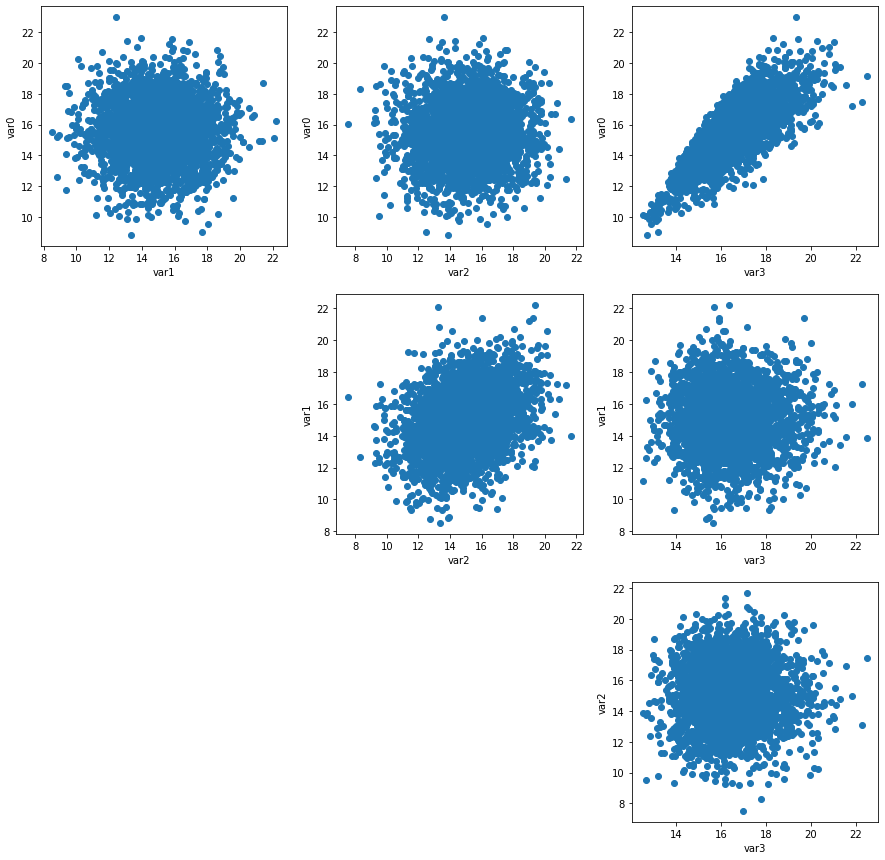

In [15]:
# 4D example
mean  = [15]*4
sigma = [2]*4
cov   = np.array([
        [1,     0,   0, 0.7],
        [  0,   1, 0.3,   0],
        [  0, 0.3,   1,   0],
        [0.7,   0,   0,   1],
    ])
skew = [-7, 0, 0, 15]
sn4D = multivariate_skew_normal(mean, sigma, cov, skew)
data = generateToys(sn4D.pdf, 10000000, xLim=[[0, 30]]*4)
plotDataProj2D(data)

In [17]:
print(data.shape[0]/1000000 *100)

0.2821


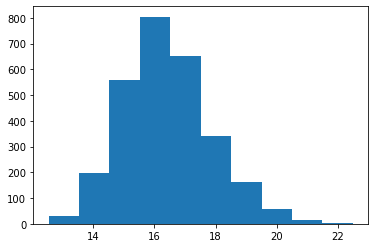